# Explore here

In [17]:
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# URLs de los conjuntos de datos
movies_url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/main/tmdb_5000_movies.csv'
credits_url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/main/tmdb_5000_credits.csv'

# Cargar los datos en DataFrames
movies_df = pd.read_csv(movies_url)
credits_df = pd.read_csv(credits_url)

In [18]:
# Unir los DataFrames usando las columnas adecuadas
merged_df = movies_df.merge(credits_df, left_on='id', right_on='movie_id')

# Seleccionar las columnas necesarias
merged_df = merged_df[['id', 'title_x', 'overview', 'genres', 'keywords', 'cast', 'crew']]
merged_df.rename(columns={'title_x': 'title'}, inplace=True)

In [19]:
# Función para convertir las columnas JSON
def convert_json_column(column):
    return column.apply(lambda x: [i['name'] for i in ast.literal_eval(x)])

# Convertir las columnas genres y keywords
merged_df['genres'] = convert_json_column(merged_df['genres'])
merged_df['keywords'] = convert_json_column(merged_df['keywords'])

# Convertir la columna cast y seleccionar los tres primeros nombres
merged_df['cast'] = merged_df['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)[:3]])

# Convertir la columna crew y seleccionar el nombre del director
def get_director(crew):
    for i in ast.literal_eval(crew):
        if i['job'] == 'Director':
            return i['name']
    return ''

merged_df['crew'] = merged_df['crew'].apply(get_director)

# Limpiar espacios en blanco en las columnas
columns_to_clean = ['genres', 'keywords', 'cast', 'crew']
for column in columns_to_clean:
    merged_df[column] = merged_df[column].apply(lambda x: ' '.join(x) if isinstance(x, list) else x.replace(' ', ''))

# Crear la columna 'tags'
merged_df['tags'] = merged_df.apply(lambda row: f"{row['overview']} {' '.join(row['genres'])} {' '.join(row['keywords'])} {' '.join(row['cast'])} {row['crew']}", axis=1)

# Seleccionar solo las columnas necesarias
final_df = merged_df[['id', 'title', 'tags']]

# Mostrar la tabla final
print(final_df.head())

       id                                     title  \
0   19995                                    Avatar   
1     285  Pirates of the Caribbean: At World's End   
2  206647                                   Spectre   
3   49026                     The Dark Knight Rises   
4   49529                               John Carter   

                                                tags  
0  In the 22nd century, a paraplegic Marine is di...  
1  Captain Barbossa, long believed to be dead, ha...  
2  A cryptic message from Bond’s past sends him o...  
3  Following the death of District Attorney Harve...  
4  John Carter is a war-weary, former military ca...  


In [23]:
# Vectorizar la columna 'tags'
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
vectors = vectorizer.fit_transform(final_df['tags']).toarray()

# Calcular la similitud del coseno
similarity = cosine_similarity(vectors)

# Función de recomendación basada en similitud del coseno
def recommend(movie):
    try:
        movie_index = final_df[final_df['title'] == movie].index[0]
        distances = similarity[movie_index]
        movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
        
        print("Películas recomendadas:")
        for i in movie_list:
            print(final_df.iloc[i[0]].title)
    except IndexError:
        print("La película no se encuentra en la base de datos.")

# Probar la función de recomendación
recommend("Spectre")

Películas recomendadas:
Never Say Never Again
Thunderball
Safe Haven
Quantum of Solace
From Russia with Love


In [24]:
# Visualización 3D de géneros y palabras clave
total_data = merged_df.copy()
total_data['genre_count'] = total_data['genres'].apply(lambda x: len(x))
total_data['keyword_count'] = total_data['keywords'].apply(lambda x: len(x))

fig = px.scatter_3d(total_data, x='genre_count', y='keyword_count', z='id', color='title', width=1000, height=500,
                    size=total_data['genre_count'].abs())
camera = dict(
    up=dict(x=1, y=3.5, z=0),
    eye=dict(x=2, y=0, z=0)
)

fig.update_layout(scene_camera=camera)
fig.show()

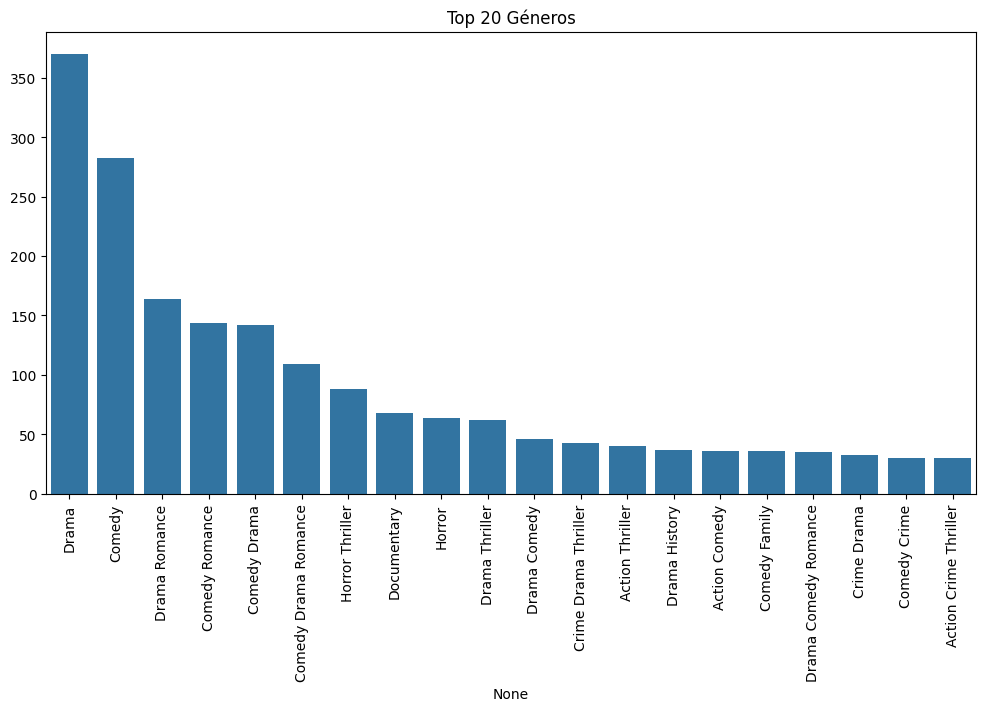

In [25]:
# Visualización de la distribución de géneros
genre_counts = merged_df['genres'].apply(lambda x: pd.Series(x)).stack().reset_index(drop=True).value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index[:20], y=genre_counts.values[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Géneros')
plt.show()
